# 🚀 โครงสร้างโปรเจกต์ตามมาตรฐาน CRISP-DM

## Phase 1: Business Understanding
วัตถุประสงค์: วิเคราะห์พฤติกรรมราคาหุ้นตามทฤษฎี Wyckoff เพื่อหาจุดกลับตัวของราคา (SC, AR, Spring) และใช้ Machine Learning ในการระบุโซนการสะสมหุ้น (Accumulation) หรือการกระจายหุ้น (Distribution) เพื่อประกอบการตัดสินใจลงทุน

## Phase 2: Data Understanding

Cell 1: Data Acquisition from Cassandra

In [19]:
# Database Connector
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np

# ตั้งค่าการเชื่อมต่อและดึงข้อมูล Raw Data
CASSANDRA_HOST = '127.0.0.1'
CASSANDRA_PORT = 9042
SYMBOL = 'TRUE'

def get_data(symbol):
    cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
    session = cluster.connect('data_stock')
    # ดึงข้อมูลย้อนหลัง 3000 แท่งเพื่อความครอบคลุมของ Cycle
    query = f"SELECT symbol, time, open, high, low, close, volume FROM candlestick_data WHERE symbol = '{symbol}' LIMIT 3000 ALLOW FILTERING"
    df = pd.DataFrame(list(session.execute(query)))
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    cluster.shutdown()
    return df.reset_index(drop=True)

df_raw = get_data(SYMBOL)
df_raw.head() # ตรวจสอบความถูกต้องของข้อมูลเบื้องต้น

,symbol,time,open,high,low,close,volume
0,TRUE,2023-03-03,8.35,8.80,8.05,8.60,785094239
1,TRUE,2023-03-07,8.70,9.00,8.20,8.40,845355873
2,TRUE,2023-03-08,8.35,8.55,8.25,8.45,157414616
3,TRUE,2023-03-09,8.50,8.50,8.20,8.35,104058318
4,TRUE,2023-03-10,8.25,8.35,8.05,8.15,91510315


## Phase 3: Data Preparation
การสร้าง Features ใหม่ๆ ตามหลักสถิติและทฤษฎี Wyckoff (Rule-based Feature Engineering)

In [20]:
def detect_wyckoff_advanced(df, window=30):
    df = df.copy()
    # คำนวณค่าทางสถิติพื้นฐานเพื่อใช้เป็นเกณฑ์ตัดสินใจ
    df['vol_ma'] = df['volume'].rolling(window=window).mean()
    df['price_spread'] = df['high'] - df['low']
    
    # 1. SC & BC Detection: ใช้กฎ Volume > 3 เท่า และทำ New High/Low ในรอบ Window
    df['SC'] = (df['volume'] > df['vol_ma'] * 3) & (df['low'] == df['low'].rolling(window).min())
    df['BC'] = (df['volume'] > df['vol_ma'] * 3) & (df['high'] == df['high'].rolling(window).max())
    
    # 2. AR (Automatic Rally): หาจุดสูงสุดที่เด้งกลับภายใน 10 วันหลังเกิด Climax
    df['AR'] = False
    for i in df.index[df['SC'] | df['BC']]:
        if i + 10 < len(df):
            if df.loc[i, 'SC']:
                ar_idx = df.loc[i:i+10, 'high'].idxmax()
                df.at[ar_idx, 'AR'] = True
            else:
                ar_idx = df.loc[i:i+10, 'low'].idxmin()
                df.at[ar_idx, 'AR'] = True

    # 3. Spring Detection: ราคาหลุดแนวรับ 60 วันแล้วดึงกลับทันที (Shakeout Pattern)
    support = df['low'].rolling(window=60).min().shift(1)
    df['SPRING'] = (df['low'] < support) & (df['close'] > support) & (df['volume'] > df['vol_ma'])
    
    return df

df_prep = detect_wyckoff_advanced(df_raw)

## Phase 4: Modeling
ใช้ XGBoost ในการจัดหมวดหมู่โซนราคา (Classification)

Cell 4: Machine Learning Model (XGBoost)

In [21]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

def prepare_ml_model(df):
    data = df.copy()
    data['returns'] = data['close'].pct_change()
    
    # กำหนด Label สมมติสำหรับสอน Model (ในงานจริงควรใช้ Label จาก Expert)
    long_ma = data['close'].rolling(50).mean()
    target = []
    for i in range(len(data)):
        if data['close'].iloc[i] < long_ma.fillna(0).iloc[i] and data['volume'].iloc[i] > data['vol_ma'].fillna(0).iloc[i]:
            target.append(1) # Accumulation Zone
        elif data['close'].iloc[i] > long_ma.fillna(0).iloc[i] and data['volume'].iloc[i] > data['vol_ma'].fillna(0).iloc[i]:
            target.append(2) # Distribution Zone
        else:
            target.append(0)
    
    data['target'] = target
    features = ['close', 'volume', 'price_spread', 'vol_ma', 'returns']
    X = data[features].fillna(0)
    
    # ใช้ XGBoost เนื่องจากเก่งในการหาความสัมพันธ์ของข้อมูลที่เป็นตารางและไม่เป็นเส้นตรง
    model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X, data['target'])
    data['zone_pred'] = model.predict(X)
    return data

df_ml  = prepare_ml_model(df_prep)

## Phase 5: Evaluation & Visualization
การประเมินผลลัพธ์ผ่านกราฟ Dashboard เพื่อตรวจสอบความสมเหตุสมผลทางเทคนิค

Cell 5: Professional Dashboard Visualization

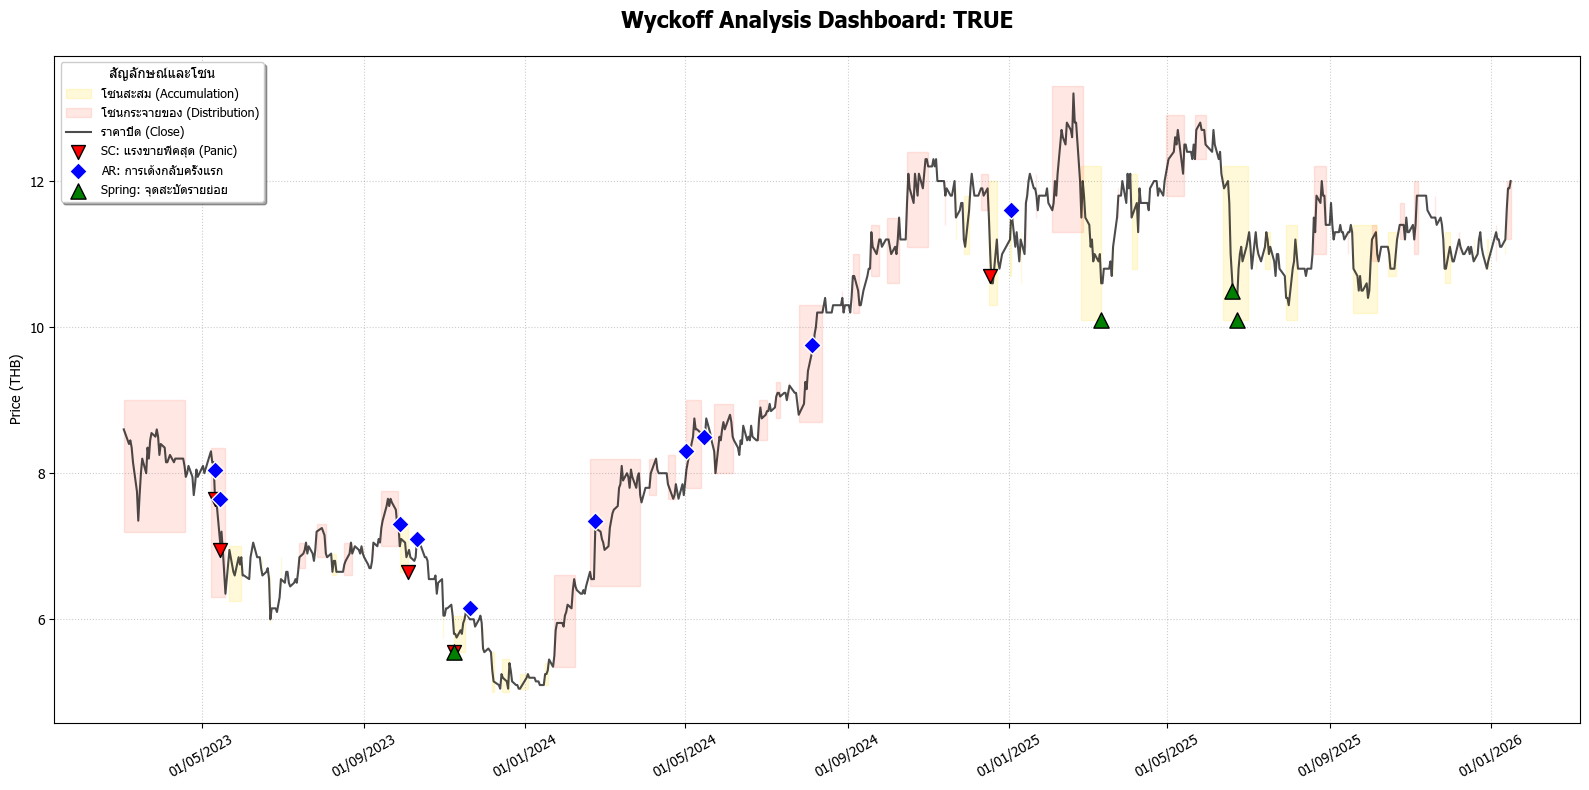

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

def plot_wyckoff_zones(df):
    # --- 1. การตั้งค่าพื้นฐาน ---
    plt.rcParams['font.family'] = 'Tahoma' 
    plt.rcParams['axes.unicode_minus'] = False
    
    MAIN_TITLE = f"Wyckoff Analysis Dashboard: {SYMBOL}"
    ACCUM_COLOR = 'gold'
    DIST_COLOR = 'tomato'
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # --- 2. ตรรกะการวาดโซน (Rectangle Zones) แบบต้นแบบ ---
    zone_types = {1: (ACCUM_COLOR, 'โซนสะสม (Accumulation)'), 
                  2: (DIST_COLOR, 'โซนกระจายของ (Distribution)')}
    
    for zone_id, (color, label_name) in zone_types.items():
        subset = df[df['zone_pred'] == zone_id].copy()
        if not subset.empty:
            # หาจุดเริ่มต้นและสิ้นสุดของแต่ละ Block เพื่อวาดสี่เหลี่ยมรูปเดียว
            subset['diff'] = subset['time'].diff().dt.days > 5
            subset['group'] = subset['diff'].cumsum()
            
            for _, group in subset.groupby('group'):
                start_t = group['time'].iloc[0]
                end_t = group['time'].iloc[-1]
                
                # คำนวณขอบเขต High/Low ของราคาทั้งช่วงเพื่อวาดกรอบ
                # เพื่อให้เหมือนต้นแบบที่แสดงกรอบ Trading Range
                box_data = df[(df['time'] >= start_t) & (df['time'] <= end_t)]
                y_min = box_data['low'].min()
                y_max = box_data['high'].max()
                
                rect_start = mdates.date2num(start_t)
                rect_width = mdates.date2num(end_t) - rect_start
                
                # วาดกรอบสี่เหลี่ยม
                rect = patches.Rectangle(
                    (rect_start, y_min), 
                    rect_width, 
                    y_max - y_min,
                    linewidth=1, 
                    edgecolor=color, 
                    facecolor=color, 
                    alpha=0.15, 
                    label=label_name, 
                    zorder=1
                )
                ax.add_patch(rect)

    # --- 3. วาดเส้นราคาและ Grid ---
    ax.plot(df['time'], df['close'], color='black', alpha=0.7, linewidth=1.5, label='ราคาปิด (Close)', zorder=3)
    ax.grid(True, linestyle=':', alpha=0.4, color='gray', zorder=2)

    # --- 4. มาร์กเหตุการณ์ Wyckoff (Markers) ---
    # ใช้ Z-order สูงสุดเพื่อให้ลอยอยู่เหนือทุกอย่าง
    sc = df[df['SC']]
    ar = df[df['AR']]
    spring = df[df['SPRING']]
    
    ax.scatter(sc['time'], sc['low'], color='red', marker='v', s=100, 
               edgecolor='black', label='SC: แรงขายพีคสุด (Panic)', zorder=10)
    
    ax.scatter(ar['time'], ar['high'], color='blue', marker='D', s=80, 
               edgecolor='white', label='AR: การเด้งกลับครั้งแรก', zorder=10)

    ax.scatter(spring['time'], spring['low'], color='green', marker='^', s=120, 
               edgecolor='black', label='Spring: จุดสะบัดรายย่อย', zorder=10)

    # --- 5. การจัดการแกน X และรูปแบบวันที่ ---
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=30)

    # --- 6. ตกแต่ง Legend และ Title ---
    ax.set_title(MAIN_TITLE, fontsize=16, pad=20, fontweight='bold')
    ax.set_ylabel("Price (THB)")
    
    # ลบ Label ซ้ำใน Legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), 
              loc='upper left', fontsize=9, title="สัญลักษณ์และโซน", frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.show()

# เรียกใช้งาน
plot_wyckoff_zones(df_ml)